In [1]:
import pandas as pd
import os, time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.optimizers import RMSprop
import tensorflow as tf
from epftoolbox.evaluation import MAE, MAPE, RMSE, rMAE
from tensorflow.keras.callbacks import EarlyStopping
from sklearn import metrics
import keras_tuner

In [2]:
os.chdir('..')
tf.random.set_seed(123)

In [3]:
# Funciones auxiliares
# Romper el dataset
def train_test_vali(serie, train_size, valida_size, ts_size):
    total_data = serie.shape[0]

    train_data = int(total_data * train_size)
    valid_data = int(total_data * valida_size)
    test_data = total_data - train_data - valid_data

    train = serie[0:train_data]
    vali = serie[train_data:train_data + valid_data]
    test = serie[train_data + valid_data:]
    return train, vali, test

#Crear dataset supervisado
def crear_dataset_supervisado(array, input_length, output_length):

    # Inicialización
    X, Y = [], []    # Listados que contendrán los datos de entrada y salida del modelo
    shape = array.shape
    if len(shape)==1: # Si tenemos sólo una serie (univariado)
        fils, cols = array.shape[0], 1
        array = array.reshape(fils,cols)
    else: # Multivariado
        fils, cols = array.shape

    # Generar los arreglos
    for i in range(fils-input_length-output_length):
        X.append(array[i:i+input_length,0:cols])
        Y.append(array[i+input_length:i+input_length+output_length,-1].reshape(output_length,1))
    
    # Convertir listas a arreglos de NumPy
    X = np.array(X)
    Y = np.array(Y)
    
    return X, Y

# Escalamiento de los datos
def escalar_dataset(data_input):
    NFEATS = data_input['x_tr'].shape[2]

    # Generar listado con "scalers"
    scalers = [MinMaxScaler(feature_range=(-1,1)) for i in range(NFEATS)]

    # Arreglos que contendrán los datasets escalados
    x_tr_s = np.zeros(data_input['x_tr'].shape)
    x_vl_s = np.zeros(data_input['x_vl'].shape)
    x_ts_s = np.zeros(data_input['x_ts'].shape)
    y_tr_s = np.zeros(data_input['y_tr'].shape)
    y_vl_s = np.zeros(data_input['y_vl'].shape)
    y_ts_s = np.zeros(data_input['y_ts'].shape)

    # Escalamiento Xs
    for i in range(NFEATS):
        x_tr_s[:,:,i] = scalers[i].fit_transform(x_tr[:,:,i])
        x_vl_s[:,:,i] = scalers[i].transform(x_vl[:,:,i])
        x_ts_s[:,:,i] = scalers[i].transform(x_ts[:,:,i])
    
    # Escalamiento Ys
    y_tr_s[:,:,0] = scalers[-1].fit_transform(y_tr[:,:,0])
    y_vl_s[:,:,0] = scalers[-1].transform(y_vl[:,:,0])
    y_ts_s[:,:,0] = scalers[-1].transform(y_ts[:,:,0])

    # Conformar ` de salida
    data_scaled = {
        'x_tr_s': x_tr_s, 'y_tr_s': y_tr_s,
        'x_vl_s': x_vl_s, 'y_vl_s': y_vl_s,
        'x_ts_s': x_ts_s, 'y_ts_s': y_ts_s,
    }

    return data_scaled, scalers[0]

# Auxiliares del modelo
def root_mean_squared_error(y_true, y_pred):
    rmse = tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred-y_true)))
    return rmse

def predecir(x, model, scaler, y_real, OUTPUT_LENGTH):
    # Calcular predicción escalada en el rango de -1 a 1
    y_pred_s = model.predict(x,verbose=0)

    # Llevar la predicción a la escala original
    y_pred = scaler.inverse_transform(y_pred_s)
    y_real = scaler.inverse_transform(y_real.reshape(-1, OUTPUT_LENGTH))

    return y_pred.flatten(), y_real.flatten()

# Función para medir el tiempo de ejecución
def elapsed_time(start_time):
    return time.time() - start_time

In [4]:
# Busqueda y mejora de los hiperparametros
def call_existing_code(filters, kernel_size, pool_size, units, lr):
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', input_shape=(24, 1)))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Flatten())
    model.add(Dense(units=units, activation='relu'))
    model.add(Dense(24, activation='linear'))
    optimizer = RMSprop(learning_rate=lr)
    model.compile(optimizer=optimizer, loss=root_mean_squared_error)
    return model

def build_model(hp):
    filters = hp.Int("filters", min_value=32, max_value=128, step=32)
    kernel_size = hp.Choice("kernel_size", values=[3, 5, 7])
    pool_size = hp.Int("pool_size", min_value=2, max_value=5)
    units = hp.Int("units", min_value=64, max_value=192, step=64)
    lr = hp.Float("lr", min_value=0.00001, max_value=0.0009, sampling="log")
    model = call_existing_code(filters=filters, kernel_size=kernel_size, pool_size=pool_size,
                               units=units, lr=lr)
    return model

Trial 30 Complete [00h 04m 20s]
val_loss: 0.015485699288547039

Best val_loss So Far: 0.015383134596049786
Total elapsed time: 01h 44m 54s
INFO:tensorflow:Oracle triggered exit


 
Training the best model
Epoch 1/50
5582/5582 [==============================] - 30s 5ms/step - loss: 0.0418 - val_loss: 0.0306
Epoch 2/50
5582/5582 [==============================] - 30s 5ms/step - loss: 0.0300 - val_loss: 0.0280
Epoch 3/50
5582/5582 [==============================] - 30s 5ms/step - loss: 0.0268 - val_loss: 0.0288
Epoch 4/50
5582/5582 [==============================] - 30s 5ms/step - loss: 0.0252 - val_loss: 0.0223
Epoch 5/50
5582/5582 [==============================] - 30s 5ms/step - loss: 0.0240 - val_loss: 0.0211
Epoch 6/50
5582/5582 [==============================] - 30s 5ms/step - loss: 0.0233 - val_loss: 0.0153
Epoch 7/50
5582/5582 [==============================] - 30s 5ms/step - loss: 0.0230 - val_loss: 0.0219
Epoch 8/50
5582/5582 [==============================] - 29s 5ms/step - loss: 0.0228 - val_loss: 0.0264
Epoch 9/50
309/309 [==============================] - 1s 3ms/step - loss: 0.0314


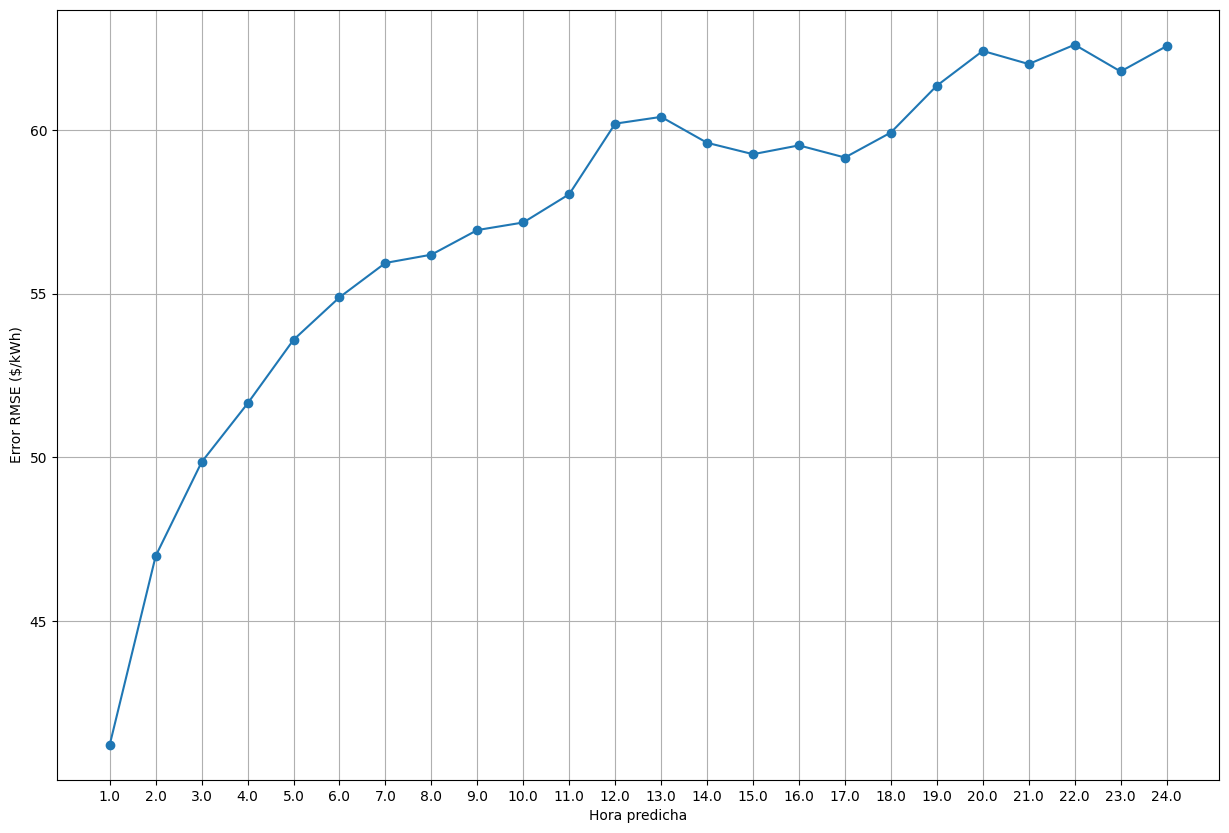

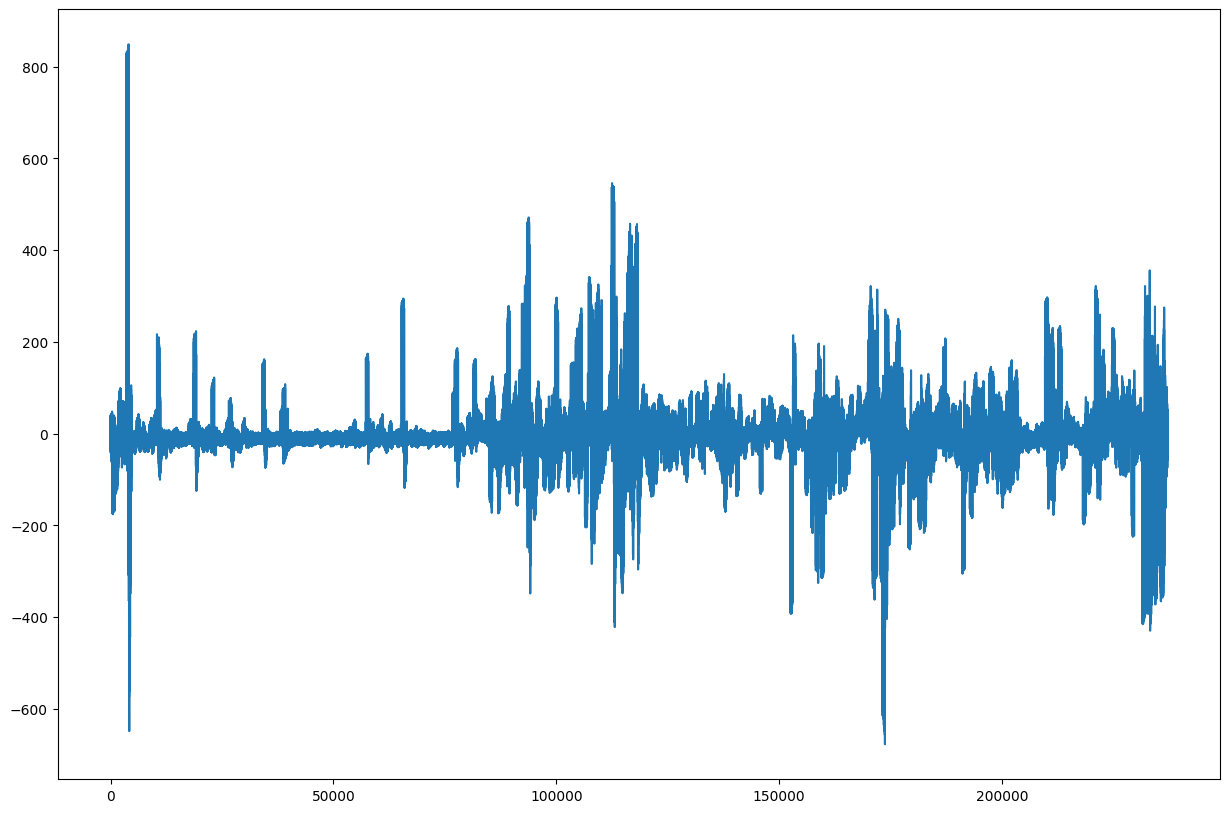

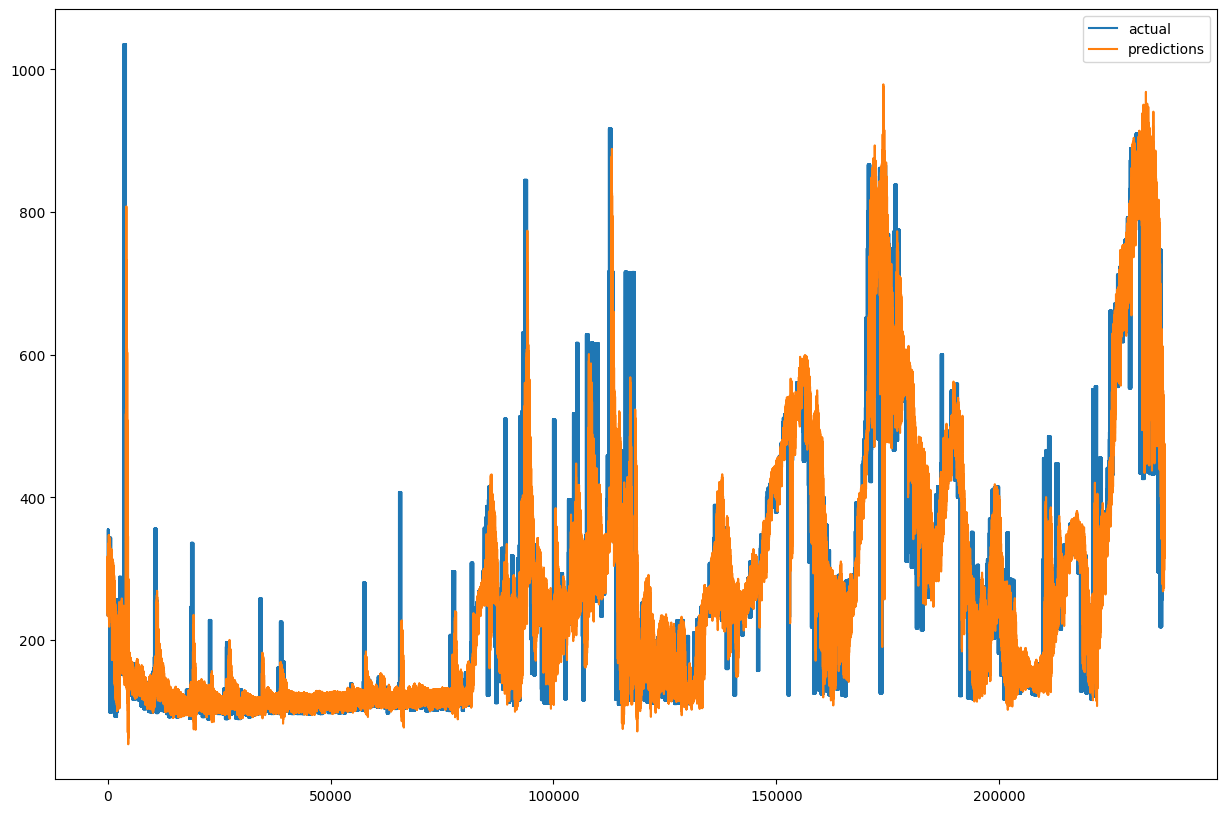

In [11]:
# Para este caso, la distribución de los datos de entrenamiento, validación y testeo se realizo de forma manual, por lo que solo se muestran los datos de la ultima ejecución
train, valid, test = 0.9,0.05,0.05
INPUT_LENGTH = 24    
OUTPUT_LENGTH = 24
epochs = 50

df = pd.read_csv('df_data_colum.csv', parse_dates=['date_hour'], index_col='date_hour')
tr, vl, ts = train_test_vali(df['price'], train, valid, test)
    
# Convertir a un problema supervisado
x_tr, y_tr = crear_dataset_supervisado(tr.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_vl, y_vl = crear_dataset_supervisado(vl.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_ts, y_ts = crear_dataset_supervisado(ts.values, INPUT_LENGTH, OUTPUT_LENGTH)
data_in = {
    'x_tr': x_tr, 'y_tr': y_tr,
    'x_vl': x_vl, 'y_vl': y_vl,
    'x_ts': x_ts, 'y_ts': y_ts,
    }
    # Escalar los datos
data_s, scaler = escalar_dataset(data_in)
x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
x_vl_s, y_vl_s = data_s['x_vl_s'], data_s['y_vl_s']
x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']

    # Importar mejor modelo
tuner = keras_tuner.BayesianOptimization(
    hypermodel=build_model,
    objective="val_loss",
    max_trials=30,
    executions_per_trial=1,
    overwrite=True,
    directory="cnn_model",
    project_name="tunning_model"
)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.003)
tuner.search(x_tr_s, y_tr_s, epochs=epochs, validation_data=(x_vl_s, y_vl_s), callbacks=[early_stopping])

architecture = tuner.get_best_hyperparameters(5)[0]

archi = []
for i in ["filters", "kernel_size", "pool_size", "units", "lr"]:
    archi.append((architecture.get(i), i))

modelo = build_model(architecture)
print(" ")
print("Training the best model")
start_time = time.time()
modelo.fit(x_tr_s, y_tr_s, epochs=epochs, validation_data=(x_vl_s, y_vl_s), callbacks=[early_stopping])
trainig_time = elapsed_time(start_time)

# models = tuner.get_best_models(num_models=2)
# modelo = models[0]

    # Comparativa de modelos
rmse_tr = modelo.evaluate(x=x_tr_s, y=y_tr_s, verbose=1)
rmse_vl = modelo.evaluate(x=x_vl_s, y=y_vl_s, verbose=1)
rmse_ts = modelo.evaluate(x=x_ts_s, y=y_ts_s, verbose=1)

# df_history = pd.DataFrame(modelo.history)
# x = df_history.index
# plt.figure(figsize=(15, 10))
# plt.plot(x, df_history['loss'], label='Función de perdida en entrenamiento')
# plt.plot(x, df_history['val_loss'], label='Función de perdida en validación')
# plt.legend()

    # Hacer predicciones
start_time = time.time()
y_ts_pred, y_real = predecir(x_ts_s, modelo, scaler, y_ts_s, OUTPUT_LENGTH)
prediction_time = elapsed_time(start_time)

    # Grafico de error (rmse) promedio por hora
y_ts_pred_s = modelo.predict(x_ts_s, verbose=0)
y_ts_pred = scaler.inverse_transform(y_ts_pred_s)
diff_cuad = np.square(y_ts.squeeze()-y_ts_pred) # 
proms = np.mean(diff_cuad, axis=0) # 1x4
rmse = np.sqrt(proms) # 1x4
t = np.linspace(1,24,24)
fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(t,rmse, marker='o')
ax.set_xlabel('Hora predicha')
ax.set_ylabel('Error RMSE ($/kWh)')
plt.xticks(ticks=t, labels=t)
plt.grid()
plt.show()

    # Grafico de errores
N = len(y_ts_pred)    # Número de predicciones (tamaño del set de prueba)
ndato = np.linspace(1,N,N)
errores = y_ts.flatten()-y_ts_pred.flatten()
plt.figure(figsize=(15, 10))
plt.plot(errores)
plt.show()

    # Grafico de predicciones
df_result = pd.DataFrame({'predictions': y_ts_pred.flatten(), 'actual': y_real.flatten()})
x = df_result.index
plt.figure(figsize=(15, 10))
plt.plot(x, df_result['actual'], label='actual')
plt.plot(x, df_result['predictions'], label='predictions')
plt.legend()
plt.show()

    # Guardar el modelo
modelo.save('cnn_model/tunning_save/best_model_{train_size}.h5'.format(train_size=train))

    # Evaluar el modelo
mean_MAE = MAE(p_pred= df_result['predictions'], p_real=df_result['actual'])
mean_RMSE = RMSE(p_pred= df_result['predictions'], p_real=df_result['actual'])
mean_MAPE = MAPE(p_pred= df_result['predictions'], p_real=df_result['actual']) * 100
mean_rMAE = rMAE(p_pred= np.array(df_result['predictions']), p_real=np.array(df_result['actual']), m='D')
r2 = metrics.r2_score(y_real.flatten(), y_ts_pred.flatten())

results = {'trainig_size': train, 'model': 'cnn', 'type': 'tunning', 'prediction_time': prediction_time, 
           'rmse_trainig': rmse_tr, 'rmse_validation': rmse_vl, 'rmse_test': rmse_ts, 'mean_MAE': mean_MAE, 
           'r2': r2, 'mean_RMSE': mean_RMSE, 'mean_MAPE': mean_MAPE, 'mean_rMAE': mean_rMAE, "architecture": [archi],
           'training_time': trainig_time}
    
df_results = pd.DataFrame(results, index=range(1))
df_results.to_csv('cnn_model/tunning_save/df_results_best_{train}.csv'.format(train=train))